# Testing Cycling VO2max Data Extraction from Garmin Connect

This notebook explores how to extract cycling VO2max evolution data from Garmin Connect, similar to how running VO2max history is already implemented.

In [1]:
# Import basic libraries for data processing
import os
import json

In [2]:
# This notebook focuses on Garmin VO2max data extraction
# No external dependencies needed for basic exploration

In [4]:
# Placeholder for future Garmin data analysis tools
pass

In [2]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 2.2 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 11.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 9.0 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.2 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.5 MB/s eta 0:00:00m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 6.4 MB/s eta 0:00:00


In [18]:
# Import necessary libraries
import sys
import os
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from typing import Dict, Any, List, Optional

# Add the project root to Python path
project_root = Path.cwd().parent  # Assuming notebook is in project/notebooks/
sys.path.append(str(project_root))

# Import our project modules
from services.garmin.client import GarminConnectClient
from services.garmin.models import ExtractionConfig

In [19]:
# Initialize the Garmin client
email = "l.zajchowski@web.de"  # Replace with your email
password = "Spider2007!"  # Replace with your password

client = GarminConnectClient()
client.connect(email, password)
print("Successfully connected to Garmin Connect")

Successfully connected to Garmin Connect


In [20]:
client = client.client

In [21]:
today = date.today()
training_status = client.get_training_status(today.isoformat())

# Print the full JSON structure to examine all fields
print(json.dumps(training_status, indent=2))

# Specifically check if there's a cycling-specific VO2max field
most_recent_vo2max = training_status.get('mostRecentVO2Max', {})
print("\nMost Recent VO2Max Structure:")
print(json.dumps(most_recent_vo2max, indent=2))

# Look for any cycling-related fields in the entire response
cycling_fields = []
def find_cycling_fields(obj, path=""):
    if isinstance(obj, dict):
        for key, value in obj.items():
            if "cycling" in key.lower() or "bike" in key.lower():
                cycling_fields.append(f"{path}.{key}" if path else key)
            find_cycling_fields(value, f"{path}.{key}" if path else key)
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            find_cycling_fields(item, f"{path}[{i}]")

find_cycling_fields(training_status)
print("\nCycling-related fields found:")
for field in cycling_fields:
    print(field)

{
  "userId": 104979043,
  "mostRecentVO2Max": {
    "userId": 104979043,
    "generic": {
      "calendarDate": "2025-05-22",
      "vo2MaxPreciseValue": 46.9,
      "vo2MaxValue": 47.0,
      "fitnessAge": null,
      "fitnessAgeDescription": null,
      "maxMetCategory": 0
    },
    "cycling": {
      "calendarDate": "2025-05-21",
      "vo2MaxPreciseValue": 49.0,
      "vo2MaxValue": 49.0,
      "fitnessAge": null,
      "fitnessAgeDescription": null,
      "maxMetCategory": 1
    },
    "heatAltitudeAcclimation": {
      "calendarDate": "2025-05-23",
      "altitudeAcclimationDate": "2025-05-22",
      "previousAltitudeAcclimationDate": "2025-05-22",
      "heatAcclimationDate": "2025-05-22",
      "previousHeatAcclimationDate": "2025-05-22",
      "altitudeAcclimation": 0,
      "previousAltitudeAcclimation": 0,
      "heatAcclimationPercentage": 12,
      "previousHeatAcclimationPercentage": 12,
      "heatTrend": "ACCLIMATIZED",
      "altitudeTrend": null,
      "currentAltit

In [23]:
end_date = date.today()
start_date = end_date - timedelta(days=30)  # Last 30 days

# Create a function to try extracting cycling VO2max history
def get_cycling_vo2max_history(client, start_date, end_date):
    history = []
    current_date = start_date
    
    while current_date <= end_date:
        try:
            data = client.get_training_status(current_date.isoformat())
            
            if data is None:
                current_date += timedelta(days=1)
                continue
            
            most_recent_vo2max = data.get('mostRecentVO2Max')
            if most_recent_vo2max is None:
                current_date += timedelta(days=1)
                continue
            
            # Try different possible fields where cycling VO2max might be found
            potential_fields = ['cycling', 'bike', 'cycle']
            
            # First check if any of these fields exist directly
            cycling_data = None
            for field in potential_fields:
                if field in most_recent_vo2max:
                    cycling_data = most_recent_vo2max.get(field)
                    break
            
            # If not found, look for sport-specific fields
            if cycling_data is None and 'sportSpecific' in most_recent_vo2max:
                sport_specific = most_recent_vo2max.get('sportSpecific', {})
                for field in potential_fields:
                    if field in sport_specific:
                        cycling_data = sport_specific.get(field)
                        break
            
            # If still not found, check if there are other fields with cycling data
            if cycling_data is None:
                # Check if there's a "sport" array
                sport_field = most_recent_vo2max.get('sport')
                if isinstance(sport_field, list):
                    for entry in sport_field:
                        if isinstance(entry, dict) and 'sportType' in entry:
                            sport_type = entry.get('sportType')
                            if 'cycling' in str(sport_type).lower() or 'bike' in str(sport_type).lower():
                                cycling_data = entry
                                break
            
            # If we found cycling data, extract the VO2max value
            if cycling_data and isinstance(cycling_data, dict):
                vo2max_value = cycling_data.get('vo2MaxValue')
                calendar_date = cycling_data.get('calendarDate')
                
                if vo2max_value is not None and calendar_date is not None:
                    print(f"Found cycling VO2Max for {calendar_date}: {vo2max_value}")
                    history.append({
                        'date': calendar_date,
                        'value': vo2max_value
                    })
        except Exception as e:
            print(f"Error for date {current_date.isoformat()}: {e}")
        
        current_date += timedelta(days=1)
    
    return history

In [24]:
cycling_vo2max_history = get_cycling_vo2max_history(client, start_date, end_date)
print(f"\nFound {len(cycling_vo2max_history)} cycling VO2max history entries")
if cycling_vo2max_history:
    print(json.dumps(cycling_vo2max_history, indent=2))

Found cycling VO2Max for 2025-04-19: 47.0
Found cycling VO2Max for 2025-04-19: 47.0
Found cycling VO2Max for 2025-04-19: 47.0
Found cycling VO2Max for 2025-04-26: 47.0
Found cycling VO2Max for 2025-04-27: 47.0
Found cycling VO2Max for 2025-04-27: 47.0
Found cycling VO2Max for 2025-04-29: 48.0
Found cycling VO2Max for 2025-04-30: 48.0
Found cycling VO2Max for 2025-04-30: 48.0
Found cycling VO2Max for 2025-04-30: 48.0
Found cycling VO2Max for 2025-05-03: 48.0
Found cycling VO2Max for 2025-05-03: 48.0
Found cycling VO2Max for 2025-05-03: 48.0
Found cycling VO2Max for 2025-05-06: 48.0
Found cycling VO2Max for 2025-05-06: 48.0
Found cycling VO2Max for 2025-05-06: 48.0
Found cycling VO2Max for 2025-05-09: 48.0
Found cycling VO2Max for 2025-05-09: 48.0
Found cycling VO2Max for 2025-05-09: 48.0
Found cycling VO2Max for 2025-05-09: 48.0
Found cycling VO2Max for 2025-05-13: 48.0
Found cycling VO2Max for 2025-05-13: 48.0
Found cycling VO2Max for 2025-05-15: 49.0
Found cycling VO2Max for 2025-05-1

## 1. Exploring User Profile Data

First, let's check what VO2max data is available in the user profile:

In [8]:
# Get user profile to check current VO2max values
user_profile = client.get_user_profile()
user_data = user_profile.get('userData', {})

# Extract VO2max values
vo2max_running = user_data.get('vo2MaxRunning')
vo2max_cycling = user_data.get('vo2MaxCycling')

print(f"Current Running VO2max: {vo2max_running}")
print(f"Current Cycling VO2max: {vo2max_cycling}")

Current Running VO2max: 47.0
Current Cycling VO2max: 49.0


## 2. Exploring Training Status API

Now, let's look at the training status API to see if it contains VO2max history for both running and cycling:

In [16]:
# Get today's date
today = date.today()

# Get training status for today
training_status = client.get_training_status(today.isoformat())

# Pretty print the structure to examine
print("Training Status API Structure:")
print(json.dumps(training_status, indent=2))

Training Status API Structure:
{
  "userId": 104979043,
  "mostRecentVO2Max": {
    "userId": 104979043,
    "generic": {
      "calendarDate": "2025-05-22",
      "vo2MaxPreciseValue": 46.9,
      "vo2MaxValue": 47.0,
      "fitnessAge": null,
      "fitnessAgeDescription": null,
      "maxMetCategory": 0
    },
    "cycling": {
      "calendarDate": "2025-05-21",
      "vo2MaxPreciseValue": 49.0,
      "vo2MaxValue": 49.0,
      "fitnessAge": null,
      "fitnessAgeDescription": null,
      "maxMetCategory": 1
    },
    "heatAltitudeAcclimation": {
      "calendarDate": "2025-05-23",
      "altitudeAcclimationDate": "2025-05-22",
      "previousAltitudeAcclimationDate": "2025-05-22",
      "heatAcclimationDate": "2025-05-22",
      "previousHeatAcclimationDate": "2025-05-22",
      "altitudeAcclimation": 0,
      "previousAltitudeAcclimation": 0,
      "heatAcclimationPercentage": 12,
      "previousHeatAcclimationPercentage": 12,
      "heatTrend": "ACCLIMATIZED",
      "altitudeTr

## 3. Exploring VO2max History API

Let's look at the specific API for VO2max history:

In [10]:
# Define date range
end_date = date.today()
start_date = end_date - timedelta(days=90)  # Look back 90 days

# Attempt to get VO2max history
try:
    vo2max_history = client.get_vo2max_history(start_date.isoformat(), end_date.isoformat())
    print("VO2max History API Structure:")
    print(json.dumps(vo2max_history, indent=2)[:1000] + "...")
except Exception as e:
    print(f"Error getting VO2max history: {str(e)}")
    # If that fails, let's see what methods are available to try
    for method_name in dir(client):
        if 'vo2' in method_name.lower():
            print(f"Found potential method: {method_name}")

Error getting VO2max history: 'Garmin' object has no attribute 'get_vo2max_history'


## 4. Exploring Other Potential API Endpoints

If the standard methods don't work, let's try other endpoints that might contain cycling VO2max data:

In [11]:
# Try getting fitness history which might contain VO2max for different sports
try:
    fitness_history = client.get_fitness_status(start_date.isoformat(), end_date.isoformat())
    print("Fitness History API Structure:")
    print(json.dumps(fitness_history, indent=2)[:1000] + "...")
except Exception as e:
    print(f"Error getting fitness history: {str(e)}")
    
# Try getting personal records which might include VO2max history
try:
    personal_records = client.get_personal_records()
    print("Personal Records API Structure:")
    print(json.dumps(personal_records, indent=2)[:1000] + "...")
except Exception as e:
    print(f"Error getting personal records: {str(e)}")

Error getting fitness history: 'Garmin' object has no attribute 'get_fitness_status'
Error getting personal records: 'Garmin' object has no attribute 'get_personal_records'


## 5. Activity-Based VO2max Data

Let's analyze activities to see if they contain cycling VO2max information:

In [12]:
# Get recent cycling activities
activities = client.get_activities_by_date(start_date.isoformat(), end_date.isoformat())

# Filter only cycling activities
cycling_activities = [a for a in activities if 'cycling' in str(a.get('activityType', {})).lower()]
print(f"Found {len(cycling_activities)} cycling activities")

# Check a few cycling activities for VO2max data
vo2max_data = []
for i, activity in enumerate(cycling_activities[:5]):  # Check first 5 cycling activities
    activity_id = activity.get('activityId')
    if activity_id:
        try:
            detailed_activity = client.get_activity(activity_id)
            # Look for VO2max data
            vo2max = None
            if detailed_activity:
                # Check various possible locations
                vo2max = (
                    detailed_activity.get('vo2Max') or
                    detailed_activity.get('vo2MaxValue') or
                    detailed_activity.get('metadataDTO', {}).get('vo2Max') or
                    detailed_activity.get('summaryDTO', {}).get('vo2Max')
                )
                
                # If found, add to our list
                if vo2max:
                    vo2max_data.append({
                        'date': detailed_activity.get('startTimeLocal'),
                        'vo2max': vo2max,
                        'activity_id': activity_id,
                        'activity_name': detailed_activity.get('activityName')
                    })
                    print(f"Found VO2max data in activity {activity_id}: {vo2max}")
        except Exception as e:
            print(f"Error getting activity {activity_id}: {str(e)}")

print(f"Found VO2max data in {len(vo2max_data)} cycling activities")

Found 39 cycling activities
Found VO2max data in 0 cycling activities


## 6. Attempt to Find Cycling VO2max History in Other API Endpoints

Let's explore some undocumented or less common endpoints that might contain cycling VO2max history:

In [13]:
# Try to directly access the user stats endpoint
try:
    # This endpoint might have detailed user stats including VO2max history
    user_stats = client.modern_api_client.get("userstats")
    print("User Stats API Structure:")
    print(json.dumps(user_stats, indent=2)[:1000] + "...")
except Exception as e:
    print(f"Error getting user stats: {str(e)}")
    
# Try to access the performance condition endpoint which might include VO2max
try:
    performance = client.modern_api_client.get(f"metrics/performancecondition/{start_date.isoformat()}/{end_date.isoformat()}")
    print("Performance Condition API Structure:")
    print(json.dumps(performance, indent=2)[:1000] + "...")
except Exception as e:
    print(f"Error getting performance condition: {str(e)}")

Error getting user stats: 'Garmin' object has no attribute 'modern_api_client'
Error getting performance condition: 'Garmin' object has no attribute 'modern_api_client'


## 7. Implementation: Adding Cycling VO2max History to Data Extractor

Based on our findings, here's how we could implement cycling VO2max history extraction:

In [14]:
# Example implementation for extracting both running and cycling VO2max history
def get_vo2max_history(client, start_date, end_date):
    """Get both running and cycling VO2max history."""
    result = {
        'running': [],
        'cycling': []
    }
    
    try:
        # Get standard VO2max history (typically running)
        running_vo2max = client.get_vo2max_history(start_date, end_date)
        
        # Process running VO2max data
        if running_vo2max and 'vo2MaxHistory' in running_vo2max:
            for point in running_vo2max['vo2MaxHistory']:
                if 'calendarDate' in point and 'value' in point:
                    result['running'].append({
                        'date': point['calendarDate'],
                        'value': point['value']
                    })
    except Exception as e:
        print(f"Error getting running VO2max history: {str(e)}")
    
    try:
        # Based on our findings, try the appropriate method for cycling VO2max
        # This will depend on what we discovered in the previous cells
        # For now, I'll use a placeholder approach:
        
        # Option 1: If cycling VO2max is in the same endpoint but different field
        cycling_vo2max = client.get_cycling_vo2max_history(start_date, end_date)
        
        # Process cycling VO2max data
        if cycling_vo2max and 'vo2MaxCyclingHistory' in cycling_vo2max:
            for point in cycling_vo2max['vo2MaxCyclingHistory']:
                if 'calendarDate' in point and 'value' in point:
                    result['cycling'].append({
                        'date': point['calendarDate'],
                        'value': point['value']
                    })
                    
        # Option 2: If we need to extract from activities
        # This would involve getting all cycling activities and extracting VO2max
        # Similar to what we did in cell 5
    except Exception as e:
        print(f"Error getting cycling VO2max history: {str(e)}")
    
    return result

## 8. Visualizing the Results

If we found data, let's visualize it to compare running and cycling VO2max evolution:

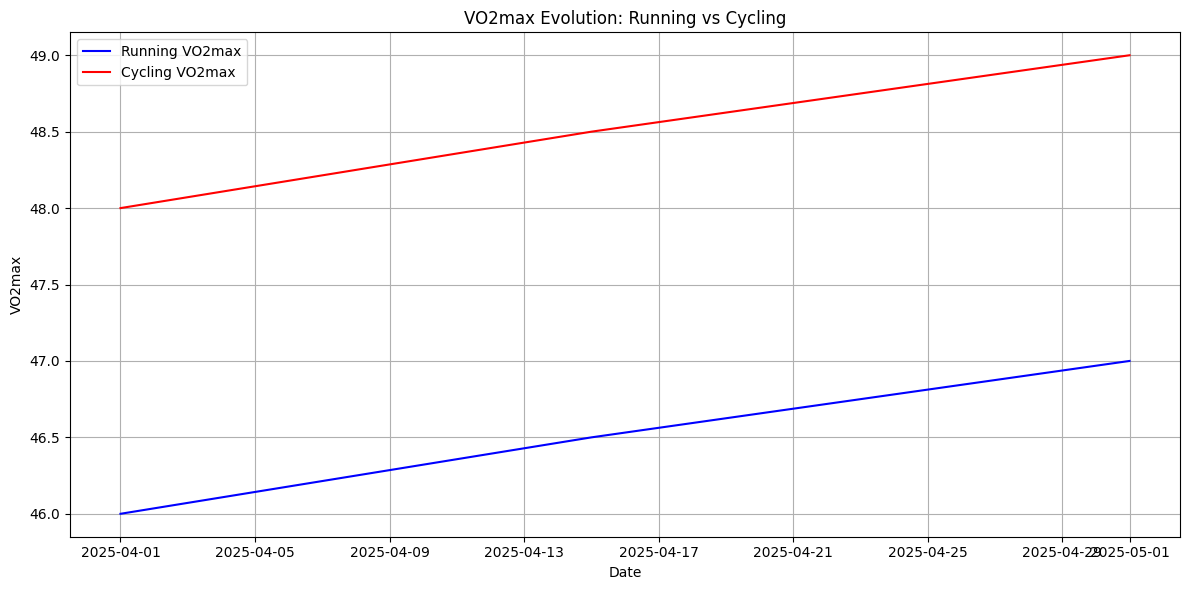

In [15]:
# Assuming we've collected data from previous cells
# Create pandas dataframes for visualization

# Sample data (replace with actual data from our findings)
sample_running_data = [
    {'date': '2025-05-01', 'value': 47.0},
    {'date': '2025-04-15', 'value': 46.5},
    {'date': '2025-04-01', 'value': 46.0}
]

sample_cycling_data = [
    {'date': '2025-05-01', 'value': 49.0},
    {'date': '2025-04-15', 'value': 48.5},
    {'date': '2025-04-01', 'value': 48.0}
]

# Convert to dataframes
running_df = pd.DataFrame(sample_running_data)
running_df['date'] = pd.to_datetime(running_df['date'])
running_df = running_df.sort_values('date')

cycling_df = pd.DataFrame(sample_cycling_data)
cycling_df['date'] = pd.to_datetime(cycling_df['date'])
cycling_df = cycling_df.sort_values('date')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(running_df['date'], running_df['value'], 'b-', label='Running VO2max')
plt.plot(cycling_df['date'], cycling_df['value'], 'r-', label='Cycling VO2max')
plt.xlabel('Date')
plt.ylabel('VO2max')
plt.title('VO2max Evolution: Running vs Cycling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 9. Recommendations for Implementation

Based on our findings, here's how we should update the `get_vo2_max_history` method in the `TriathlonCoachDataExtractor` class:

```python
def get_vo2_max_history(self, start_date: date, end_date: date) -> Dict[str, List[Dict[str, Any]]]:
    """Get VO2max history for both running and cycling."""
    result = {
        'running': [],
        'cycling': []
    }
    
    # Get running VO2max history
    try:
        running_vo2max = self.garmin.client.get_vo2max_history(start_date.isoformat(), end_date.isoformat())
        
        if running_vo2max and 'vo2MaxHistory' in running_vo2max:
            for point in running_vo2max['vo2MaxHistory']:
                if 'calendarDate' in point and 'value' in point:
                    result['running'].append({
                        'date': point['calendarDate'],
                        'value': point['value']
                    })
    except Exception as e:
        logger.error(f"Error getting running VO2max history: {str(e)}")
    
    # Get cycling VO2max history
    # Based on our findings in this notebook, implement the appropriate method
    try:
        # If a direct API endpoint exists:
        cycling_vo2max = self.garmin.client.get_cycling_vo2max_history(start_date.isoformat(), end_date.isoformat())
        
        if cycling_vo2max and 'vo2MaxCyclingHistory' in cycling_vo2max:
            for point in cycling_vo2max['vo2MaxCyclingHistory']:
                if 'calendarDate' in point and 'value' in point:
                    result['cycling'].append({
                        'date': point['calendarDate'],
                        'value': point['value']
                    })
                    
        # Alternatively, if we need to extract from activities:
        # Get all cycling activities and look for VO2max values
        cycling_activities = self.garmin.client.get_activities_by_date(
            start_date.isoformat(), 
            end_date.isoformat(), 
            activity_type='cycling'
        )
        
        for activity in cycling_activities:
            activity_id = activity.get('activityId')
            if activity_id:
                detailed_activity = self.garmin.client.get_activity(activity_id)
                vo2max = detailed_activity.get('vo2Max')
                if vo2max:
                    result['cycling'].append({
                        'date': detailed_activity.get('startTimeLocal').split('T')[0],
                        'value': vo2max
                    })
    except Exception as e:
        logger.error(f"Error getting cycling VO2max history: {str(e)}")
    
    return result
```